# Overview of this notebook

* introduction - global forecasting
* global forecast without exogeneous data
* global forecast with exogeneous data
* contributor credits

In [1]:
import warnings

warnings.filterwarnings("ignore")

## Global Forecasting with deep learning models and transformers

1. What is global forecast about?
  
    A lot of deep learning models will 
    
    - train on large dataset which containing many time series from many instances 
    - predict on time series from other instances beyond training data. 
    
    The ability to train on many series and predict beyond training data is called global forecast.

2. How is global forecast formulated?

   - train on dataset containing $n$ time series $\{x_{i_1}, x_{i_2}, x_{i_3}, ..., x_{i_n}\}$
   - predict on another set of time series $\{x_{j_1}, x_{j_2}, x_{j_3}, ..., x_{j_m}\}$
   - $m$ is not required to be equal to $n$
   - there might or might not be intersection between the sets $\{i_1,.., i_n\}$ and $\{j_1, ... j_m\}$

To check the global forecast ability of one forecaster in sktime, you can check the `capability:global_forecasting` tag.

In [2]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingDeepAR

PytorchForecastingDeepAR().get_tag(
    "capability:global_forecasting"
)  # should return True

True

### SKU future volume analysis and prediction

The example is a demand forecast from the [Stallion kaggle competition](https://www.kaggle.com/datasets/utathya/future-volume-prediction).

Explanaion from kaggle:

Country Beeristan, a high potential market, accounts for nearly 10% of Stallion & Co.’s global beer sales. Stallion & Co. has a large portfolio of products distributed to retailers through wholesalers (agencies). There are thousands of unique wholesaler-SKU/products combinations. In order to plan its production and distribution as well as help wholesalers with their planning, it is important for Stallion & Co. to have an accurate estimate of demand at SKU level for each wholesaler.

Currently demand is estimated by sales executives, who generally have a “feel” for the market and predict the net effect of forces of supply, demand and other external factors based on past experience. The more experienced a sales exec is in a particular market, the better a job he does at estimating. Joshua, the new Head of S&OP for Stallion & Co. just took an analytics course and realized he can do the forecasts in a much more effective way. He approaches you, the best data scientist at Stallion, to transform the exercise of demand forecasting.

We use a simplified data structure to showcase the global forecasting ability with sktime

In [3]:
import pandas as pd
data = pd.read_csv("data/stallion_data.csv")
data["date"]=pd.to_datetime(data["date"])
data = data.set_index(["agency","sku","date"])
data # data with 1 target column (volume), and 19 exogeneous data columns

volume  price_regular  avg_population_2017  \
agency    sku    date                                                      
Agency_01 SKU_01 2013-01-01   80.676    1141.500000               153733   
                 2013-02-01   98.064    1141.500000               153733   
                 2013-03-01  133.704    1179.345820               153733   
                 2013-04-01  147.312    1226.687500               153733   
                 2013-05-01  175.608    1230.331104               153733   
...                              ...            ...                  ...   
Agency_60 SKU_23 2017-08-01    1.980    4254.975000              2180611   
                 2017-09-01    1.260    4256.796429              2180611   
                 2017-10-01    0.990    4262.625000              2180611   
                 2017-11-01    0.090    4262.625000              2180611   
                 2017-12-01    2.250    4257.126000              2180611   

                             avg_yearly_household_income_2017  easter_day  \
agency    sku    date                                                       
Agency_01 SKU_01 2013-01-01                            120207           0   
                 2013-02-01                            120207           0   
                 2013-03-01                            120207           1   
                 2013-04-01                            120207           0   
                 2013-05-01                            120207           0   
...                                                       ...         ...   
Agency_60 SKU_23 2017-08-01                            211936           0   
                 2017-09-01                            211936           0   
                 2017-10-01                            211936           0   
                 2017-11-01                            211936           0   
                 2017-12-01                            211936           0   

                             good_friday  new_year  christmas  labor_day  \
agency    sku    date                                                      
Agency_01 SKU_01 2013-01-01            0         1          0          0   
                 2013-02-01            0         0          0          0   
                 2013-03-01            1         0          0          0   
                 2013-04-01            0         0          0          0   
                 2013-05-01            0         0          0          1   
...                                  ...       ...        ...        ...   
Agency_60 SKU_23 2017-08-01            0         0          0          0   
                 2017-09-01            0         0          0          0   
                 2017-10-01            0         0          0          0   
                 2017-11-01            0         0          0          0   
                 2017-12-01            0         0          1          0   

                             independence_day  revolution_day_memorial  \
agency    sku    date                                                    
Agency_01 SKU_01 2013-01-01                 0                        0   
                 2013-02-01                 0                        0   
                 2013-03-01                 0                        0   
                 2013-04-01                 0                        0   
                 2013-05-01                 0                        0   
...                                       ...                      ...   
Agency_60 SKU_23 2017-08-01                 0                        0   
                 2017-09-01                 1                        0   
                 2017-10-01                 0                        0   
                 2017-11-01                 0                        1   
                 2017-12-01                 0                        0   

                             regional_games  fifa_u_17_world_cup  \
agency    sku    da

In [4]:
y=data["volume"].to_frame()
x=data.drop(columns="volume")

#### Global Forecasting without exogeneous data

First, let's try to fit and predict without exogeneous data

In [5]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9], is_relative=True, freq="MS")

from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(y, test_size=0.1, train_size=0.9, shuffle=False)
y_true = y_test.groupby(level=[0,1]).apply(lambda x: x.droplevel([0,1]).iloc[-max(fh):])
y_test = y_test.groupby(level=[0,1]).apply(lambda x: x.droplevel([0,1]).iloc[:-max(fh)])

`y_train` is the series we want to fit on which contains the first 90% of the time series instances.

In [6]:
y_train

volume
agency    sku    date                  
Agency_01 SKU_01 2013-01-01    80.67600
                 2013-02-01    98.06400
                 2013-03-01   133.70400
                 2013-04-01   147.31200
                 2013-05-01   175.60800
...                                 ...
Agency_55 SKU_05 2017-08-01  1058.95050
                 2017-09-01   909.68025
                 2017-10-01  1156.84560
                 2017-11-01   902.71500
                 2017-12-01  1202.59800

[18900 rows x 1 columns]

`y_test` is the series we want to predict on which contains the last 10% of the time series instances.

In [7]:
y_test

volume
agency    sku    date                
Agency_56 SKU_01 2013-01-01  2999.160
                 2013-02-01  3541.212
                 2013-03-01  4057.992
                 2013-04-01  4152.276
                 2013-05-01  4885.488
...                               ...
Agency_60 SKU_23 2016-11-01     0.360
                 2016-12-01     3.510
                 2017-01-01     2.160
                 2017-02-01     2.520
                 2017-03-01     1.710

[1785 rows x 1 columns]

You can see that `y_train` and `y_test` are different on hierarchical level which indicates that they come from different instances.

We can initialize a gloabl forecaster to fit on `y_train` and predict on `y_test`.

In [8]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingNBeats

model = PytorchForecastingNBeats(
    trainer_params={
        "max_epochs": 10,  # for quick test
    },
)

In [9]:
model.fit(y=y_train, fh=fh)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 1.6 M  | train
-------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.588     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 63/63 [00:04<00:00, 14.48it/s, v_num=70, train_loss_step=1.520, val_loss=1.310, train_loss_epoch=1.410]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:04<00:00, 14.21it/s, v_num=70, train_loss_step=1.520, val_loss=1.310, train_loss_epoch=1.410]


PytorchForecastingNBeats(trainer_params={'max_epochs': 10})

Then we can predict on `y_test` which is not included in `y_train`.

In [10]:
y_pred = model.predict(y=y_test, fh=fh)
y_pred

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


volume
agency    sku    date                   
Agency_56 SKU_01 2017-04-01  3701.887207
                 2017-05-01  3621.166992
                 2017-06-01  3592.275879
                 2017-07-01  3605.979980
                 2017-08-01  3616.348633
...                                  ...
Agency_60 SKU_23 2017-08-01     1.799389
                 2017-09-01     1.516928
                 2017-10-01     1.287264
                 2017-11-01     1.352445
                 2017-12-01     1.832303

[315 rows x 1 columns]

`y_pred` have the same instance index as `y_test`.

We can plot one series to see the result. As we train the model for a few epochs, we can not expect too much.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='volume'>)

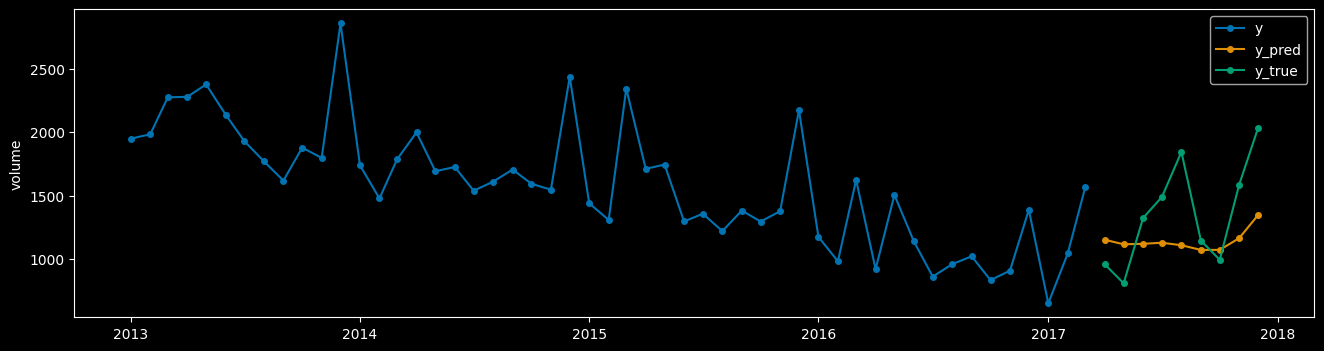

In [11]:
from sktime.utils.plotting import plot_series
ins=("Agency_59","SKU_04")
plot_series(
    y_test.loc[ins],
    y_pred.loc[ins],
    y_true.loc[ins],
    labels=["y", "y_pred", "y_true"],
)

#### Global Forecasting with exogeneous data

Then let's try to fit and predict with exogeneous data

When we predict with exogeneous data, we need to pass both `X` and `y` to `predict`.

`X` must contain all historical values and the time points to be predicted while `y` should only contain the historical values but not the time points to be predicted.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, train_size=0.9, shuffle=False
)
y_true = y_test.groupby(level=[0,1]).apply(lambda x: x.droplevel([0,1]).iloc[-max(fh):])
y_test = y_test.groupby(level=[0,1]).apply(lambda x: x.droplevel([0,1]).iloc[:-max(fh)])

`X_train` and `y_train` have the same time index from 2000-01-01 to 2000-01-10.

However `y_test` is shorter than `X_test`. 

`X_test` has the time index from 2013-01-01 to 2017-12-01 but `y_test` only has the time index from 2013-01-01 to 2017-03-01. 

This is because we don't know the values from 2017-4-01 to 2017-12-01 of `y_test` which are going to be forecasted.

In [13]:
y_test

volume
agency    sku    date                
Agency_56 SKU_01 2013-01-01  2999.160
                 2013-02-01  3541.212
                 2013-03-01  4057.992
                 2013-04-01  4152.276
                 2013-05-01  4885.488
...                               ...
Agency_60 SKU_23 2016-11-01     0.360
                 2016-12-01     3.510
                 2017-01-01     2.160
                 2017-02-01     2.520
                 2017-03-01     1.710

[1785 rows x 1 columns]

`y_test` is shorter than `X_test` as `y_test` only contains the historical values not the time points to be predicted.

In [14]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingNHiTS

model = PytorchForecastingNHiTS(
    trainer_params={
        "max_epochs": 10,  # for quick test
    },
)

model.fit(y=y_train, X=X_train, fh=fh)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | MASE           | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 2.0 M  | train
-----------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.033     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 63/63 [00:04<00:00, 14.17it/s, v_num=72, train_loss_step=1.530, val_loss=1.380, train_loss_epoch=1.390]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:04<00:00, 13.83it/s, v_num=72, train_loss_step=1.530, val_loss=1.380, train_loss_epoch=1.390]


PytorchForecastingNHiTS(trainer_params={'max_epochs': 10})

Now we can predict on `y_test` with `X_test`.

In [15]:
y_pred = model.predict(fh=fh, X=X_test, y=y_test)
y_pred

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


volume
agency    sku    date                   
Agency_56 SKU_01 2017-04-01  3953.122070
                 2017-05-01  3852.943848
                 2017-06-01  3825.829102
                 2017-07-01  3614.406982
                 2017-08-01  3872.367188
...                                  ...
Agency_60 SKU_23 2017-08-01     1.563540
                 2017-09-01     1.560177
                 2017-10-01     1.234308
                 2017-11-01     1.515041
                 2017-12-01     1.931867

[315 rows x 1 columns]

We can plot one series to see the result. As we train the model for a few epochs, we can not expect too much.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='volume'>)

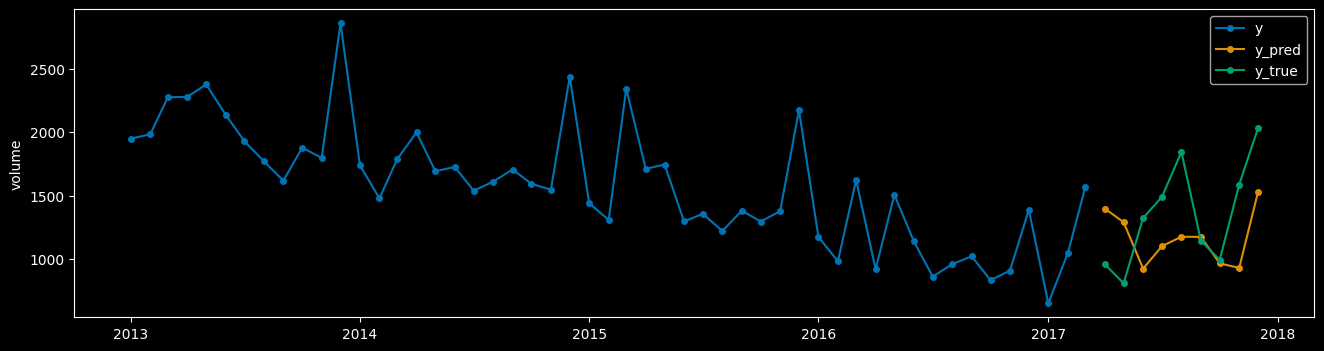

In [16]:
ins=("Agency_59","SKU_04")
plot_series(
    y_test.loc[ins],
    y_pred.loc[ins],
    y_true.loc[ins],
    labels=["y", "y_pred", "y_true"],
)